# Wheat Kernel Classification

Create a classification model to determine the type of wheat seed based on kernel attributes

In [7]:
%matplotlib inline

import os
import csv
import pickle
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts 

from yellowbrick.classifier import ClassBalance, ConfusionMatrix, ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sns

## Data Loading

Load data as a Pandas DataFrame

In [2]:
df = pd.read_csv("data/seeds.csv", delim_whitespace=True, header=None)
df.columns = ['area', 'perimeter', 'compactness', 'kernel_length', 'kernel_width', 'asymmetry_coeff', 'groove_length', 'type']

In [3]:
df.describe()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coeff,groove_length,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [4]:
# Check to ensure all series are numeric either float or int
df.dtypes

area               float64
perimeter          float64
compactness        float64
kernel_length      float64
kernel_width       float64
asymmetry_coeff    float64
groove_length      float64
type                 int64
dtype: object

## Basic Visualization

Correlation among variables

The code below runs a basic correlation amongst all variables except type and generates a heat map to better understand said correlations

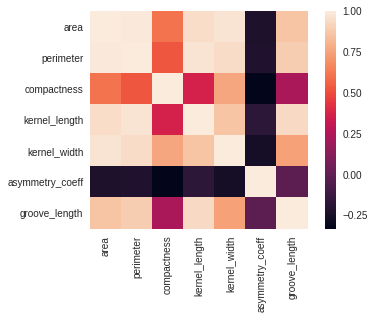

In [8]:
# Create a new dataframe that is just features
features_df = df[[col for col in df.columns if col !='type']]
#Calculate the correlation of the features
cor = features_df.corr() 
#Plot the correlation as heat map
sns.heatmap(cor, square = True) 

### Correlation Analysis

* All the size based features (area, perimeter, kernel_width kernel_length and groove_length) all are strongly correlated with each other and inversely correlated with compactness (ie the more area the less compact a kernel will be)
* Asymmtrey_coefficient doesn't seem to correlate with any of the other features 
* When I group the features by type and take the min, max, mean. Area, Perimeter, and Asymmetry Coefficient jump out as being most distinct between the three types.

In [9]:
# Feature averages by feature type
df.groupby('type').agg(['min', 'mean', 'max']).transpose()

type                          1          2          3
area            min   11.230000  15.380000  10.590000
                mean  14.334429  18.334286  11.873857
                max   17.080000  21.180000  13.370000
perimeter       min   12.630000  14.660000  12.410000
                mean  14.294286  16.135714  13.247857
                max   15.460000  17.250000  13.950000
compactness     min    0.839200   0.845200   0.808100
                mean   0.880070   0.883517   0.849409
                max    0.918300   0.910800   0.897700
kernel_length   min    4.902000   5.363000   4.899000
                mean   5.508057   6.148029   5.229514
                max    6.053000   6.675000   5.541000
kernel_width    min    2.850000   3.231000   2.630000
                mean   3.244629   3.677414   2.853771
                max    3.683000   4.033000   3.232000
asymmetry_coeff min    0.765100   1.472000   1.661000
                mean   2.667403   3.644800   4.788400
                max    6.685000   6.682000   8.456000
groove_length   min    4.519000   5.144000   4.745000
                mean   5.087214   6.020600   5.116400
                max    5.877000   6.550000   5.491000

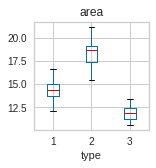

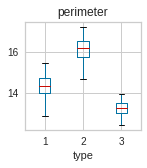

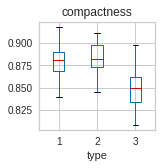

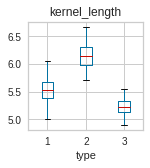

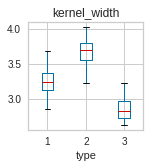

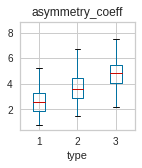

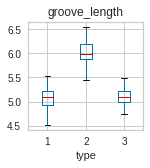

In [10]:
# Box Plots of Features by Type
for col in features_df.columns:
    axes = df.boxplot(by="type", column=col, layout=(1,1), figsize=(2, 2))
    fig = axes.get_figure()
    fig.suptitle('')
    

## Split Train and Test Data


In [11]:
features = [col for col in df.columns if col !='type']

target = 'type'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)


In [12]:
# Always check the shape of X and y makes sense 
print("X Train shape is {} y train shape is {}".format(
    X_train.shape, y_train.shape
))

print("X Test shape is {} y Test shape is {}".format(
    X_test.shape, y_test.shape
))

X Train shape is (168, 7) y train shape is (168,)
X Test shape is (42, 7) y Test shape is (42,)


## Fit a Classifier

In [13]:
def simple_evaluate_model(model):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    print("f1: {}".format(f1_score(y_test, y_hat, average='weighted')))

In [14]:
# Simple Evaluation
clf1 = GradientBoostingClassifier()
simple_evaluate_model(clf1)

f1: 0.907102157102157


In [17]:
cross_val_score(clf1, X_train, y_train, cv=12, scoring='f1_macro').mean()

0.92339265672599014

In [18]:
clf2 = LogisticRegression()
simple_evaluate_model(clf2)

f1: 0.8823680823680824


In [19]:
cross_val_score(clf2, X_train, y_train, cv=12, scoring='f1_macro').mean()

0.93490660573993889

In [20]:
clf3 = GaussianNB()
simple_evaluate_model(clf3)

f1: 0.8355739590522198


In [22]:
cross_val_score(clf3, X_train, y_train, cv=12, scoring='f1_macro').mean()

0.91951659451659451

In [24]:
clf4 = SVC()
simple_evaluate_model(clf4)

f1: 0.85999185999186


In [30]:
cross_val_score(clf4, X_train, y_train, cv=12, scoring='f1_macro').mean()

0.90954385121051773

In [31]:
from sklearn.gaussian_process import GaussianProcessClassifier
clf5 =  GaussianProcessClassifier()
simple_evaluate_model(clf5)

f1: 0.8823680823680824


In [32]:
cross_val_score(clf5, X_train, y_train, cv=12, scoring='f1_macro').mean()

0.90393217893217892

## Model Management

In [ ]:
def internal_params(estimator):
    for attr in dir(estimator):
        if attr.endswith("_") and not attr.startswith("_"):
            yield attr

In [ ]:
def save_model(model, path=None):
    if path is None:
        path = model.__class__.__name__ + ".pkl"
    with open(path, 'wb') as f:
        pickle.dump(model, f)

In [ ]:
#Pick the model that best fits and save the model
list(internal_params(clf))
save_model(clf)